In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def plot_series(time, series, format = "-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [40]:
PATH = "./lab8/Sunspots.csv"
df = pd.read_csv(PATH)
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.head()

,index,Unnamed: 0,Monthly Mean Total Sunspot Number
Date,,,
1749-01-31,0,0,96.7
1749-02-28,1,1,104.3
1749-03-31,2,2,116.7
1749-04-30,3,3,92.8
1749-05-31,4,4,141.7


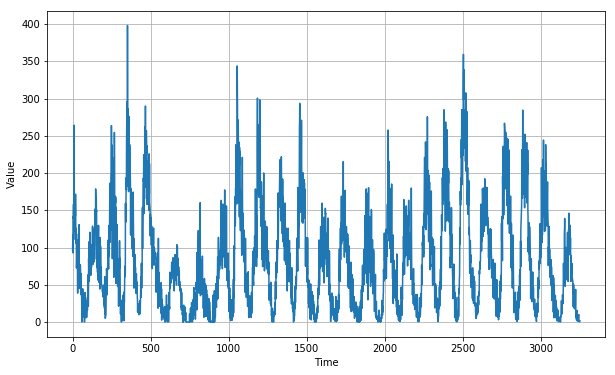

In [41]:
# Загружаем датасет и конвертируем датасет в массив временного ряда
import csv
time_step = []
temps = []

with open(PATH) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step = 0
    for row in reader:
        temps.append(float(row[2]))
        time_step.append(step)
        step = step + 1
    
series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

Вычислим тренд и сезонность. Используем метод STL (A Seasonal-Trend Decomposition Procedure Based on Loess)

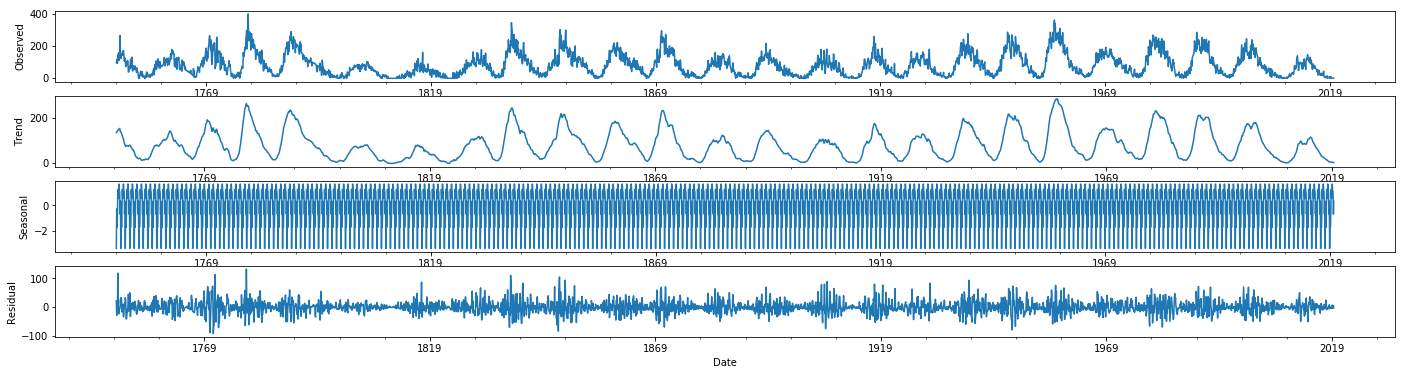

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decomposition = seasonal_decompose(df['Monthly Mean Total Sunspot Number'], model='additive')
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(24,6))
ax1.set_ylabel('Observed')
ax2.set_ylabel('Trend')
ax3.set_ylabel('Seasonal')
ax4.set_ylabel('Residual')

seasonal_decomposition.observed.plot(ax=ax1)
seasonal_decomposition.trend.plot(ax=ax2)
seasonal_decomposition.seasonal.plot(ax=ax3)
seasonal_decomposition.resid.plot(ax=ax4)

c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\matplotlib\pyplot.py:935: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  return gcf().gca(**kwargs)


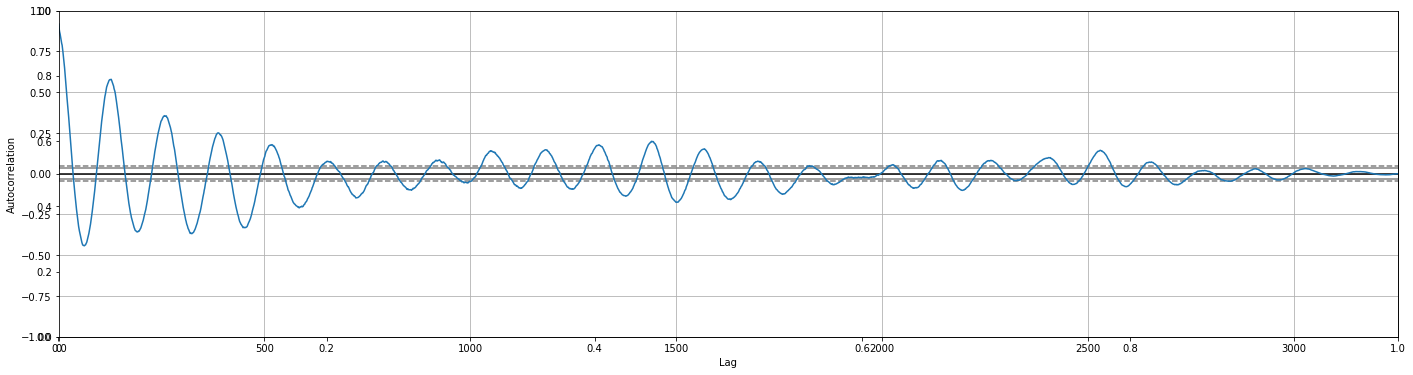

In [43]:
from pandas.plotting import autocorrelation_plot

plt.subplots(1,1, figsize=(24,6))

autocorrelation_plot(df['Monthly Mean Total Sunspot Number'].values.tolist())

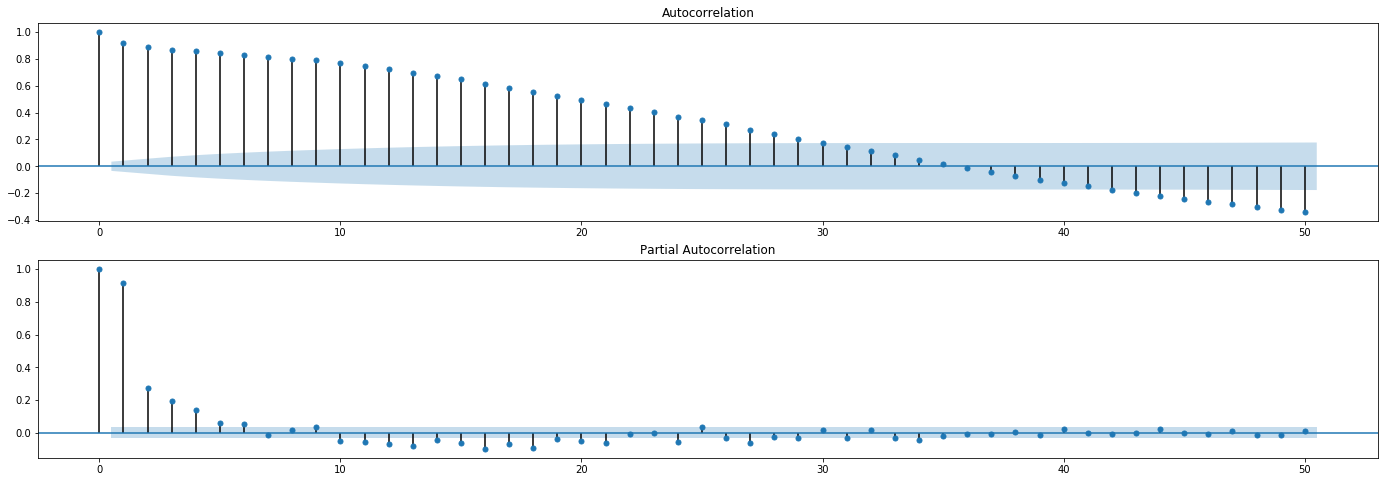

In [44]:
import statsmodels.api as sm

fig = plt.figure(figsize=(24,8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(df['Monthly Mean Total Sunspot Number'], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(df['Monthly Mean Total Sunspot Number'], lags=50, ax=ax2)
plt.show()

In [5]:
#Задаем параметры для модели 
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
#Подготовка датасета 
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
#Задаем модель 
tf.keras.backend.clear_session()
tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 5, strides=1, padding="same", activation="relu", input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
])


model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

Epoch 1/100
46/46 [==============================] - 31s 665ms/step - loss: 66.1490 - mae: 66.6674
Epoch 2/100
46/46 [==============================] - 10s 226ms/step - loss: 27.2088 - mae: 27.4180
Epoch 3/100
46/46 [==============================] - 11s 231ms/step - loss: 7.9659 - mae: 8.3826
Epoch 4/100
46/46 [==============================] - 11s 242ms/step - loss: 5.2228 - mae: 5.6729
Epoch 5/100
46/46 [==============================] - 11s 244ms/step - loss: 2.7785 - mae: 3.2482
Epoch 6/100
46/46 [==============================] - 11s 229ms/step - loss: 2.4478 - mae: 2.8843
Epoch 7/100
46/46 [==============================] - 10s 228ms/step - loss: 2.8339 - mae: 3.2686
Epoch 8/100
46/46 [==============================] - 10s 226ms/step - loss: 2.3110 - mae: 2.8155
Epoch 9/100
46/46 [==============================] - 10s 223ms/step - loss: 2.6526 - mae: 3.0773
Epoch 10/100
46/46 [==============================] - 12s 257ms/step - loss: 1.8351 - mae: 2.2284
Epoch 11/100
46/46 [=====

In [9]:
#Выполняем предсказание результатов натренированой моделью 
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [10]:
#Оцениваем модель, используя метрику MAE (cредний модуль отклонения (MAE – Mean Absolute Error или MAD – Mean
#Absolute Deviation)
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.252498

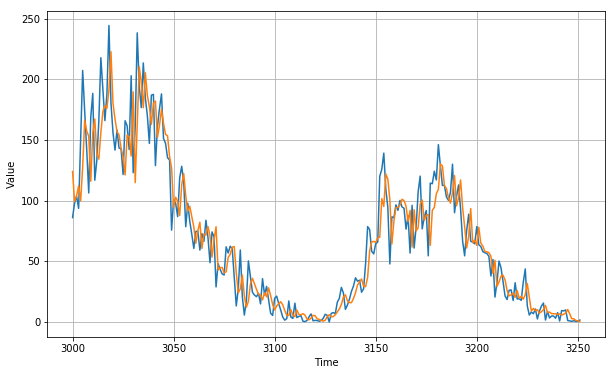

In [11]:
#визуализация полученного результата 
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Использование ARIMA

In [59]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [60]:
split_time = -300
train_data = df['Monthly Mean Total Sunspot Number'][:split_time]
test_data = df['Monthly Mean Total Sunspot Number'][split_time:]

In [61]:
arima_model = auto_arima(df['Monthly Mean Total Sunspot Number'],
                           n_jobs=-1,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=False, random=True,
                           n_fits=1000)

In [62]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3252
Model:               SARIMAX(3, 0, 2)   Log Likelihood              -15035.377
Date:                Thu, 23 Apr 2020   AIC                          30084.755
Time:                        02:39:48   BIC                          30127.364
Sample:                             0   HQIC                         30100.018
                               - 3252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0923      0.030      3.061      0.002       0.033       0.151
ar.L1          2.3049      0.020    114.993      0.000       2.266       2.344
ar.L2         -1.6486      0.040    -41.469      0.000      -1.727      -1.571
ar.L3          0.3425      0.020     16.838      0.000       0.303       0.382
ma.L1         -1.7716      0.014   -129.954      0.000      -1.798      -1.745
ma.L2          0.8013      0.013     59.974      0.000       0.775       0.827
sigma2       603.4269      9.701     62.203      0.000     584.414     622.440
===================================================================================
Ljung-Box (Q):                       82.84   Jarque-Bera (JB):              1444.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.46
Prob(H) (two-sided):                  0.27   Kurtosis:                         6.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
history = train_data.values.tolist()

arima_predictions = list()
for t in range(len(test_data)):
    model = ARIMA(history, order=(3,0,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test_data[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=32.533272, expected=32.600000
predicted=32.403902, expected=45.800000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=38.963515, expected=46.300000
predicted=40.359751, expected=21.600000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=28.441420, expected=19.400000
predicted=26.003095, expected=22.500000
predicted=26.491972, expected=20.400000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=24.537336, expected=18.200000
predicted=22.788049, expected=15.700000
predicted=20.567561, expected=30.600000
predicted=27.613721, expected=14.000000
predicted=19.750253, expected=14.900000
predicted=19.322594, expected=13.300000
predicted=17.916237, expected=7.700000
predicted=14.528397, expected=12.600000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.058406, expected=6.800000
predicted=12.729415, expected=7.600000
predicted=12.542098, expected=16.500000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.766301, expected=11.800000
predicted=14.699613, expected=19.700000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=18.932096, expected=3.000000
predicted=11.115557, expected=0.700000
predicted=9.004213, expected=24.900000
predicted=20.925579, expected=14.000000
predicted=16.911701, expected=7.400000
predicted=13.741481, expected=11.000000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.407467, expected=12.100000
predicted=16.277210, expected=23.000000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=22.312151, expected=25.400000
predicted=24.887453, expected=20.800000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=23.735656, expected=12.900000
predicted=20.350538, expected=35.700000
predicted=32.381971, expected=59.700000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=47.142382, expected=32.800000
predicted=36.946202, expected=50.400000
predicted=47.161053, expected=55.500000
predicted=52.321831, expected=44.500000
predicted=49.073129, expected=50.200000
predicted=53.163353, expected=82.000000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=71.331908, expected=70.600000
predicted=69.573686, expected=74.000000
predicted=73.662587, expected=90.500000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=84.644282, expected=96.700000
predicted=91.326876, expected=121.100000
predicted=107.604335, expected=132.000000
predicted=118.510732, expected=78.500000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=95.534284, expected=97.300000
predicted=104.690876, expected=119.200000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=117.143400, expected=86.000000
predicted=102.275328, expected=98.000000
predicted=107.481181, expected=103.500000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=110.462540, expected=93.600000
predicted=105.530225, expected=149.600000
predicted=134.194110, expected=207.200000
predicted=169.048580, expected=173.500000
predicted=160.404516, expected=142.300000
predicted=148.552849, expected=106.300000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=130.160878, expected=168.700000
predicted=160.246746, expected=188.300000
predicted=173.537311, expected=116.800000
predicted=140.179786, expected=133.100000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=145.391241, expected=165.700000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=161.023682, expected=217.700000
predicted=190.034642, expected=191.500000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=182.319081, expected=165.900000
predicted=171.458155, expected=188.000000
predicted=182.884432, expected=244.300000
predicted=214.139033, expected=180.500000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=187.010093, expected=156.000000
predicted=173.572172, expected=141.600000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=162.778945, expected=158.100000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=167.323477, expected=143.300000
predicted=157.088962, expected=142.600000
predicted=153.157021, expected=121.500000
predicted=138.826433, expected=165.800000
predicted=157.267358, expected=161.700000
predicted=155.032566, expected=142.100000
predicted=144.330552, expected=202.900000
predicted=174.132883, expected=123.000000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=135.837216, expected=161.500000
predicted=151.900503, expected=238.200000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=192.368538, expected=194.100000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=176.521515, expected=176.600000
predicted=169.581715, expected=213.400000
predicted=189.200369, expected=184.600000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=177.778299, expected=170.200000
predicted=170.454239, expected=147.100000
predicted=157.126504, expected=186.900000
predicted=174.842608, expected=187.500000
predicted=176.175913, expected=128.800000
predicted=146.015708, expected=161.000000
predicted=158.025686, expected=175.600000
predicted=164.472754, expected=187.900000
predicted=171.291118, expected=151.200000
predicted=153.485038, expected=147.200000
predicted=149.260029, expected=135.300000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=140.602250, expected=133.500000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=136.528497, expected=75.700000
predicted=103.363929, expected=100.700000
predicted=108.571147, expected=97.900000
predicted=102.598213, expected=86.800000
predicted=92.913788, expected=118.700000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=105.310033, expected=128.300000
predicted=109.993482, expected=115.400000
predicted=103.834957, expected=78.500000
predicted=84.051537, expected=97.800000
predicted=90.414472, expected=82.900000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=81.361514, expected=72.200000
predicted=73.453266, expected=60.600000
predicted=64.637435, expected=74.600000
predicted=68.554167, expected=74.800000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=67.298131, expected=59.200000
predicted=58.142951, expected=72.800000
predicted=63.301166, expected=66.500000
predicted=59.583157, expected=83.800000
predicted=68.028544, expected=69.700000
predicted=61.877601, expected=48.800000
predicted=50.886295, expected=74.200000
predicted=62.318971, expected=70.100000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=61.203460, expected=28.900000
predicted=40.042658, expected=48.100000
predicted=46.867087, expected=43.500000
predicted=43.651707, expected=39.600000
predicted=40.412676, expected=38.700000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=38.765624, expected=61.900000
predicted=50.053732, expected=56.800000
predicted=49.025692, expected=62.400000
predicted=52.880139, expected=60.500000
predicted=53.364735, expected=37.200000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=42.307672, expected=13.200000
predicted=28.574411, expected=27.500000
predicted=32.913122, expected=59.300000
predicted=48.364947, expected=20.900000
predicted=30.133210, expected=5.700000
predicted=20.285254, expected=17.300000
predicted=23.403779, expected=50.300000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=39.475050, expected=37.200000
predicted=34.533268, expected=24.500000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=28.471457, expected=22.200000
predicted=26.789028, expected=20.800000
predicted=25.269177, expected=23.700000
predicted=26.267935, expected=14.900000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=21.339184, expected=35.700000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=31.318221, expected=22.300000
predicted=25.513030, expected=29.300000
predicted=29.165330, expected=18.400000
predicted=24.043094, expected=7.200000
predicted=17.586515, expected=5.400000
predicted=15.314791, expected=19.500000
predicted=21.246340, expected=21.300000
predicted=22.527009, expected=15.100000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


predicted=19.574829, expected=9.800000
predicted=16.610661, expected=4.000000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.959920, expected=1.500000
predicted=10.605962, expected=2.800000
predicted=10.201004, expected=17.300000
predicted=17.157170, expected=4.100000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.893712, expected=2.900000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.847651, expected=15.500000
predicted=15.833259, expected=3.600000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.383964, expected=4.600000
predicted=10.503113, expected=5.200000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.752492, expected=0.600000


In [ ]:
#визуализация полученного результата 
plt.figure(figsize=(10, 6))
plot_series(test_data.keys(), test_data.values)
plot_series(test_data.keys(), arima_predictions)

In [ ]:
#Оцениваем модель, используя метрику MAE (cредний модуль отклонения (MAE – Mean Absolute Error или MAD – Mean
#Absolute Deviation)
mse = tf.keras.metrics.mean_absolute_error(test_data.values, arima_predictions).numpy()
mse.mean()